# 1. Cleaning

In [720]:
# Load disaster dataset
import pandas as pd

df_disaster = pd.read_csv("data/natural_disaster_data.csv")

In [721]:
df_disaster.head()

,AGRN,Start date,End date,Duration,State,Disaster Types
0,886,20/01/2020,NaN,NaN,ACT,Storm
1,887,23/01/2020,03/02/2020,11.0,QLD,"Storm, Flood"
2,888,08/01/2020,16/01/2020,8.0,WA,Cyclone
3,898,15/01/2020,NaN,NaN,NSW,"Storm, Flood"
4,899,04/02/2020,09/02/2020,5.0,WA,"Storm, Flood"


In [722]:
print(df_disaster.dtypes)

AGRN                int64
Start date         object
End date           object
Duration          float64
State              object
Disaster Types     object
dtype: object


In [723]:
print(df_disaster.shape)

(304, 6)


In [724]:
# missing values
print(df_disaster.isnull().sum())

AGRN                0
Start date         18
End date          161
Duration          161
State               0
Disaster Types      0
dtype: int64


In [725]:
# Convert Start date and End date to datetime
df_disaster["Start date"] = pd.to_datetime(df_disaster["Start date"], dayfirst=True, errors="coerce")
df_disaster["End date"]   = pd.to_datetime(df_disaster["End date"], dayfirst=True, errors="coerce")

# Quick check
df_disaster[["Start date", "End date"]].head()

,Start date,End date
0,2020-01-20,NaT
1,2020-01-23,2020-02-03
2,2020-01-08,2020-01-16
3,2020-01-15,NaT
4,2020-02-04,2020-02-09


In [726]:
# Verify Duration = End - Start
df_disaster["calc_duration"] = (df_disaster["End date"] - df_disaster["Start date"]).dt.days

# Compare with provided Duration column
duration_check = (df_disaster["calc_duration"] == df_disaster["Duration"]).value_counts()

print("Duration matches:", duration_check.get(True, 0))
print("Duration mismatches:", duration_check.get(False, 0))

# Show mismatches
df_disaster[df_disaster["calc_duration"] != df_disaster["Duration"]].head()

Duration matches: 143
Duration mismatches: 161


,AGRN,Start date,End date,Duration,State,Disaster Types,calc_duration
0,886,2020-01-20,NaT,NaN,ACT,Storm,NaN
3,898,2020-01-15,NaT,NaN,NSW,"Storm, Flood",NaN
6,901,2020-02-01,NaT,NaN,VIC,"Storm, Flood",NaN
11,906,2020-01-14,NaT,NaN,VIC,"Storm, Flood",NaN
14,910,2020-04-03,NaT,NaN,VIC,"Storm, Flood",NaN


In [727]:
# Replace Duration with calc_duration
df_disaster["Duration"] = df_disaster["calc_duration"]

# Drop the helper column
df_disaster = df_disaster.drop(columns=["calc_duration"])

# Check
df_disaster.head()

,AGRN,Start date,End date,Duration,State,Disaster Types
0,886,2020-01-20,NaT,NaN,ACT,Storm
1,887,2020-01-23,2020-02-03,11.0,QLD,"Storm, Flood"
2,888,2020-01-08,2020-01-16,8.0,WA,Cyclone
3,898,2020-01-15,NaT,NaN,NSW,"Storm, Flood"
4,899,2020-02-04,2020-02-09,5.0,WA,"Storm, Flood"


In [728]:
# ✅ Ensure Disaster Types are standardized tuples of single-type strings
df_disaster["Disaster Types"] = (
    df_disaster["Disaster Types"]
      .apply(lambda x: tuple(str(t).strip().title() for t in (list(x) if isinstance(x,(list,tuple)) else str(x).split(","))))
)

In [729]:
df_disaster.head()

,AGRN,Start date,End date,Duration,State,Disaster Types
0,886,2020-01-20,NaT,NaN,ACT,"(Storm,)"
1,887,2020-01-23,2020-02-03,11.0,QLD,"(Storm, Flood)"
2,888,2020-01-08,2020-01-16,8.0,WA,"(Cyclone,)"
3,898,2020-01-15,NaT,NaN,NSW,"(Storm, Flood)"
4,899,2020-02-04,2020-02-09,5.0,WA,"(Storm, Flood)"


In [730]:
# Fix spelling: Earthqack → Earthquake
df_disaster["Disaster Types"] = df_disaster["Disaster Types"].apply(
    lambda x: tuple("Earthquake" if d.lower() == "earthqack" else d for d in x)
)

# Display unique disasters
unique_disasters = pd.Series(
    sorted({d for types in df_disaster["Disaster Types"] for d in types}),
    name="Disaster Types"
)
print(unique_disasters)

0      Bushfire
1       Cyclone
2    Earthquack
3         Flood
4     Landslide
5      Rainfall
6         Storm
7       Tornado
Name: Disaster Types, dtype: object


In [731]:
# 🛠️ Fix spelling: Earthqack → Earthquake
df_disaster["Disaster Types"] = df_disaster["Disaster Types"].apply(
    lambda x: tuple("Earthquake" if d.lower() == "earthquack" else d for d in x)
)

# ✅ Display unique disasters in Series format
unique_disasters = pd.Series(
    sorted({d for types in df_disaster["Disaster Types"] for d in types}),
    name="Disaster Types"
)
print(unique_disasters)

0      Bushfire
1       Cyclone
2    Earthquake
3         Flood
4     Landslide
5      Rainfall
6         Storm
7       Tornado
Name: Disaster Types, dtype: object


In [732]:
# show earthquake events
df_eq = df_disaster[df_disaster["Disaster Types"].apply(lambda x: "Earthquake" in x)]
df_eq


,AGRN,Start date,End date,Duration,State,Disaster Types
90,999,2021-09-22,NaT,NaN,VIC,"(Earthquake,)"
237,1146,2024-08-06,NaT,NaN,VIC,"(Earthquake,)"
250,1159,2024-08-23,2024-11-12,81.0,NSW,"(Earthquake,)"


In [733]:
# Fix Earthquake, Tornado, Landslide durations
instant_types = ["Earthquake", "Tornado", "Landslide"]

df_disaster.loc[
    df_disaster["Disaster Types"].apply(lambda x: any(d in instant_types for d in x)),
    "End date"
] = df_disaster["Start date"]

# Recalculate Duration again
df_disaster["Duration"] = (df_disaster["End date"] - df_disaster["Start date"]).dt.days + 1

# Check only the fixed rows
print(
    df_disaster[df_disaster["Disaster Types"].apply(lambda x: any(d in instant_types for d in x))][
        ["Start date", "End date", "Duration", "Disaster Types"]
    ]
)

    Start date   End date  Duration             Disaster Types
73  2021-10-14 2021-10-14       1.0           (Storm, Tornado)
83  2021-09-30 2021-09-30       1.0           (Storm, Tornado)
90  2021-09-22 2021-09-22       1.0              (Earthquake,)
152 2023-01-14 2023-01-14       1.0           (Storm, Tornado)
154 2023-03-23 2023-03-23       1.0  (Storm, Flood, Landslide)
225 2024-05-10 2024-05-10       1.0           (Storm, Tornado)
237 2024-08-06 2024-08-06       1.0              (Earthquake,)
250 2024-08-23 2024-08-23       1.0              (Earthquake,)


In [734]:
# average disaster duration by type ordered by duration
avg_duration = df_disaster.explode("Disaster Types").groupby("Disaster Types")["Duration"].mean().sort_values(ascending=False)
print(avg_duration)

Disaster Types
Bushfire      19.489362
Rainfall      13.666667
Flood         13.373333
Cyclone       12.461538
Storm         11.957143
Earthquake     1.000000
Landslide      1.000000
Tornado        1.000000
Name: Duration, dtype: float64


In [735]:
# top events by duration
top_events = df_disaster.nlargest(10, "Duration")
top_events


,AGRN,Start date,End date,Duration,State,Disaster Types
140,1046,2022-12-20,2023-04-30,132.0,QLD,"(Storm, Flood)"
131,1037,2022-10-06,2023-01-13,100.0,VIC,"(Storm, Flood)"
245,1154,2024-09-12,2024-11-15,65.0,QLD,"(Bushfire,)"
171,1078,2023-09-08,2023-11-07,61.0,QLD,"(Bushfire,)"
292,1202,2025-03-21,2025-05-19,60.0,QLD,"(Storm, Flood)"
143,1048,2023-01-30,2023-03-24,54.0,QLD,"(Bushfire,)"
172,1079,2023-10-18,2023-12-08,52.0,QLD,"(Bushfire,)"
29,935,2020-08-01,2020-09-19,50.0,NT,"(Bushfire,)"
35,941,2020-11-09,2020-12-23,45.0,QLD,"(Bushfire,)"
105,1011,2022-02-22,2022-04-05,43.0,QLD,"(Storm, Flood)"


In [736]:
# find missing values
print(df_disaster.isnull().sum())

AGRN                0
Start date         18
End date          154
Duration          154
State               0
Disaster Types      0
dtype: int64


In [737]:
# missing counts per disaster type
tmp = (
    df_disaster
      .assign(type=df_disaster["Disaster Types"].apply(list))
      .explode("type")
)

# count unique AGRN rows with missing values
missing_counts = (
    tmp.groupby("type")[["AGRN", "Start date", "End date", "Duration", "State"]]
       .apply(lambda g: g.drop_duplicates("AGRN").isna().sum())
)

# Add total row
missing_counts.loc["Total"] = df_disaster.isna().sum()

print(missing_counts)

            AGRN  Start date  End date  Duration  State
type                                                   
Bushfire       0           2        24        24      0
Cyclone        0           3         5         5      0
Earthquake     0           0         0         0      0
Flood          0          10        79        79      0
Landslide      0           0         0         0      0
Rainfall       0           2         3         3      0
Storm          0           6       109       109      0
Tornado        0           0         0         0      0
Total          0          18       154       154      0


In [738]:
# Drop rows with any NaN values
df_disaster = df_disaster.dropna().reset_index(drop=True)

print("Before cleaning:", df_disaster.shape)
print("After cleaning:", df_disaster_clean.shape)

Before cleaning: (150, 6)
After cleaning: (150, 6)


In [739]:
df_disaster.head()

,AGRN,Start date,End date,Duration,State,Disaster Types
0,887,2020-01-23,2020-02-03,12.0,QLD,"(Storm, Flood)"
1,888,2020-01-08,2020-01-16,9.0,WA,"(Cyclone,)"
2,899,2020-02-04,2020-02-09,6.0,WA,"(Storm, Flood)"
3,900,2020-02-08,2020-02-14,7.0,QLD,"(Storm, Flood)"
4,902,2020-01-15,2020-02-20,37.0,VIC,"(Storm, Flood)"


In [740]:
# sort by start date
df_disaster = df_disaster.sort_values("Start date").reset_index(drop=True)
df_disaster.head()


,AGRN,Start date,End date,Duration,State,Disaster Types
0,888,2020-01-08,2020-01-16,9.0,WA,"(Cyclone,)"
1,902,2020-01-15,2020-02-20,37.0,VIC,"(Storm, Flood)"
2,887,2020-01-23,2020-02-03,12.0,QLD,"(Storm, Flood)"
3,899,2020-02-04,2020-02-09,6.0,WA,"(Storm, Flood)"
4,900,2020-02-08,2020-02-14,7.0,QLD,"(Storm, Flood)"


In [741]:
# fix all the feature naming
df_disaster.columns = df_disaster_clean.columns.str.strip().str.lower().str.replace(" ", "_")

In [742]:
# save the cleaned DataFrame to a new CSV file
df_disaster.to_csv("data/natural_disaster_data_cleaned.csv", index=False)
df_disaster.head()


,agrn,start_date,end_date,duration,state,disaster_types
0,888,2020-01-08,2020-01-16,9.0,WA,"(Cyclone,)"
1,902,2020-01-15,2020-02-20,37.0,VIC,"(Storm, Flood)"
2,887,2020-01-23,2020-02-03,12.0,QLD,"(Storm, Flood)"
3,899,2020-02-04,2020-02-09,6.0,WA,"(Storm, Flood)"
4,900,2020-02-08,2020-02-14,7.0,QLD,"(Storm, Flood)"


# 2. EDA

In [743]:
# load the cleaned DataFrame
df_disaster_clean = pd.read_csv("data/natural_disaster_data_cleaned.csv")
df_disaster_clean.head()


,agrn,start_date,end_date,duration,state,disaster_types
0,888,2020-01-08,2020-01-16,9.0,WA,"('Cyclone',)"
1,902,2020-01-15,2020-02-20,37.0,VIC,"('Storm', 'Flood')"
2,887,2020-01-23,2020-02-03,12.0,QLD,"('Storm', 'Flood')"
3,899,2020-02-04,2020-02-09,6.0,WA,"('Storm', 'Flood')"
4,900,2020-02-08,2020-02-14,7.0,QLD,"('Storm', 'Flood')"


In [744]:
# ensure start_date is datetime
df_disaster_clean_exploded["start_date"] = pd.to_datetime(df_disaster_clean_exploded["start_date"], errors="coerce")
df_disaster_clean_exploded["end_date"]   = pd.to_datetime(df_disaster_clean_exploded["end_date"], errors="coerce")

In [745]:
import ast

def parse_types(x):
    if pd.isna(x): 
        return tuple()
    if isinstance(x, (list, tuple)):
        return tuple(x)
    x = str(x).strip()
    if (x.startswith("(") and x.endswith(")")) or (x.startswith("[") and x.endswith("]")):
        try:
            val = ast.literal_eval(x)
            return tuple(val) if isinstance(val, (list, tuple)) else (str(val),)
        except Exception:
            return (x,)
    return tuple(t.strip().title() for t in x.split(",") if t.strip())

# ✅ Fix the column in your loaded df
df_disaster_clean["disaster_types"] = df_disaster_clean["disaster_types"].apply(parse_types)

# quick check
print(df_disaster_clean["disaster_types"].head(10).tolist())

[('Cyclone',), ('Storm', 'Flood'), ('Storm', 'Flood'), ('Storm', 'Flood'), ('Storm', 'Flood'), ('Storm', 'Flood'), ('Flood',), ('Storm', 'Flood'), ('Storm', 'Flood', 'Cyclone'), ('Storm', 'Flood')]


In [746]:
# 🔍 Explode so each disaster type has its own row
df_disaster_clean_exploded = df_disaster_clean.explode("disaster_types").reset_index(drop=True)

# quick check
df_disaster_clean_exploded.head()

,agrn,start_date,end_date,duration,state,disaster_types
0,888,2020-01-08,2020-01-16,9.0,WA,Cyclone
1,902,2020-01-15,2020-02-20,37.0,VIC,Storm
2,902,2020-01-15,2020-02-20,37.0,VIC,Flood
3,887,2020-01-23,2020-02-03,12.0,QLD,Storm
4,887,2020-01-23,2020-02-03,12.0,QLD,Flood


In [747]:
print(df_disaster_clean_exploded.shape)

(222, 6)


In [748]:
# Most frequent disaster types
disaster_counts = df_disaster_clean_exploded["disaster_types"].value_counts()
print(disaster_counts)

disaster_types
Flood         75
Storm         70
Bushfire      47
Cyclone       13
Rainfall       9
Tornado        4
Earthquake     3
Landslide      1
Name: count, dtype: int64


In [749]:
# Average duration per disaster type (days)
avg_duration = (
    df_disaster_clean_exploded.groupby("disaster_types")["duration"]
    .mean()
    .sort_values(ascending=False)
)
print(avg_duration)

disaster_types
Bushfire      19.489362
Rainfall      13.666667
Flood         13.373333
Cyclone       12.461538
Storm         11.957143
Earthquake     1.000000
Landslide      1.000000
Tornado        1.000000
Name: duration, dtype: float64


In [ ]:
# add year column
df_disaster_clean_exploded["year"] = df_disaster_clean_exploded["start_date"].dt.year

# disaster counts per year
disasters_per_year = df_disaster_clean_exploded.groupby("year")["disaster_types"].count()
print(disasters_per_year)

year
2020    35
2021    33
2022    39
2023    43
2024    60
2025    12
Name: disaster_types, dtype: int64


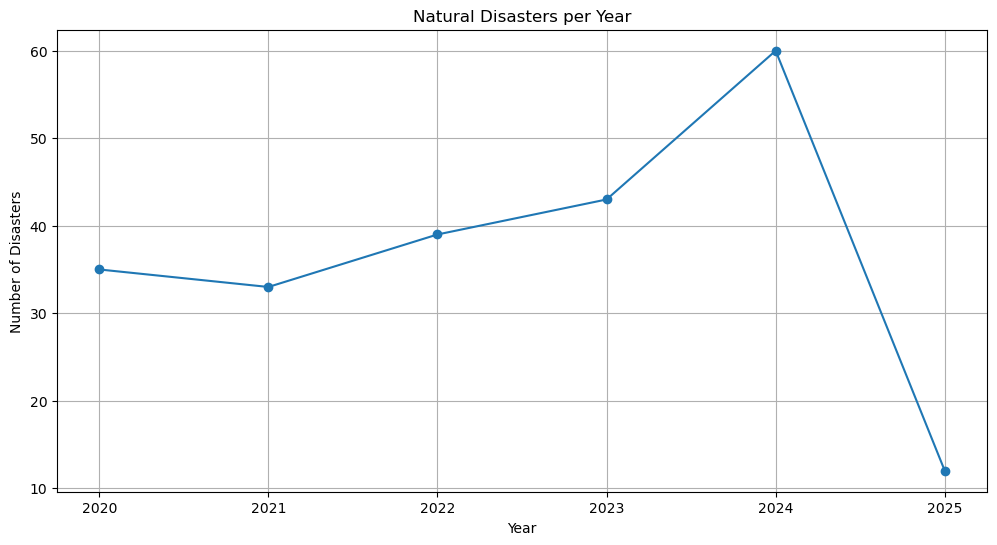

In [756]:
# visual for disaster counts per year
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(disasters_per_year.index, disasters_per_year.values, marker='o')
plt.title("Natural Disasters per Year")
plt.xlabel("Year")
plt.ylabel("Number of Disasters")
plt.grid()
plt.show()


In [757]:
# disaster counts per month
disasters_per_month = df_disaster_clean_exploded.groupby(df_disaster_clean_exploded["start_date"].dt.to_period("M"))["disaster_types"].count()
print(disasters_per_month)


start_date
2020-01     5
2020-02    14
2020-03     2
2020-04     4
2020-08     3
2020-10     1
2020-11     2
2020-12     4
2021-01     3
2021-02     3
2021-03     4
2021-04     3
2021-05     2
2021-06     4
2021-07     2
2021-09     3
2021-10     4
2021-11     2
2021-12     3
2022-01     8
2022-02    11
2022-03     2
2022-04     4
2022-05     2
2022-06     1
2022-08     2
2022-09     4
2022-10     2
2022-11     1
2022-12     2
2023-01     3
2023-03     7
2023-04     1
2023-07     1
2023-08     1
2023-09     6
2023-10     7
2023-11     4
2023-12    13
2024-01    12
2024-02     4
2024-03     6
2024-05     4
2024-06     5
2024-07     2
2024-08     4
2024-09     4
2024-10     3
2024-11     6
2024-12    10
2025-01     2
2025-02     3
2025-03     5
2025-04     2
Freq: M, Name: disaster_types, dtype: int64


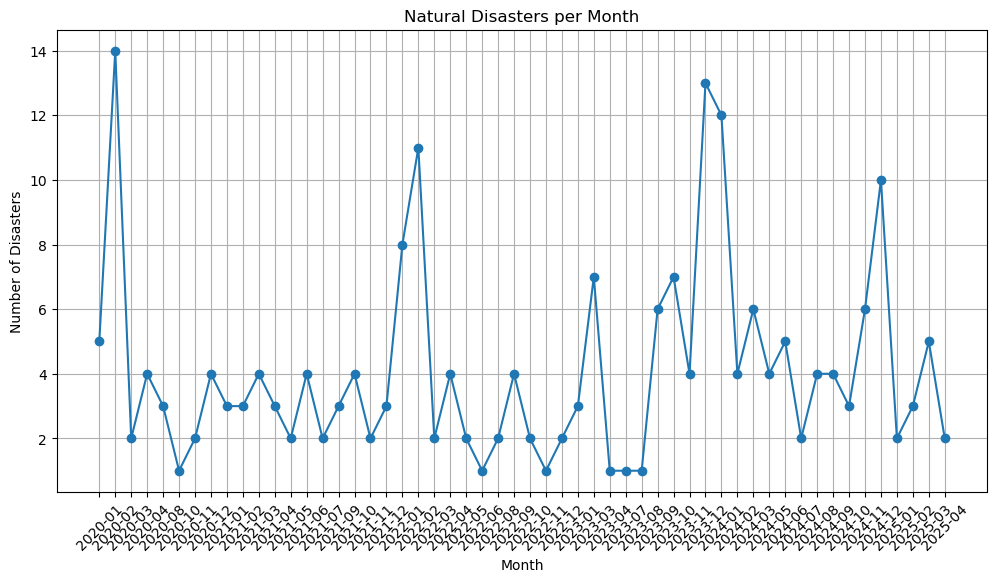

In [758]:
# visual for disaster counts per month
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(disasters_per_month.index.astype(str), disasters_per_month.values, marker='o')
plt.title("Natural Disasters per Month")
plt.xlabel("Month")
plt.ylabel("Number of Disasters")
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [759]:
# Which states have the most disasters
state_counts = df_disaster_clean_exploded["state"].value_counts()
print(state_counts)

state
QLD    83
WA     65
NSW    43
VIC    13
NT      8
SA      5
TAS     3
ACT     2
Name: count, dtype: int64


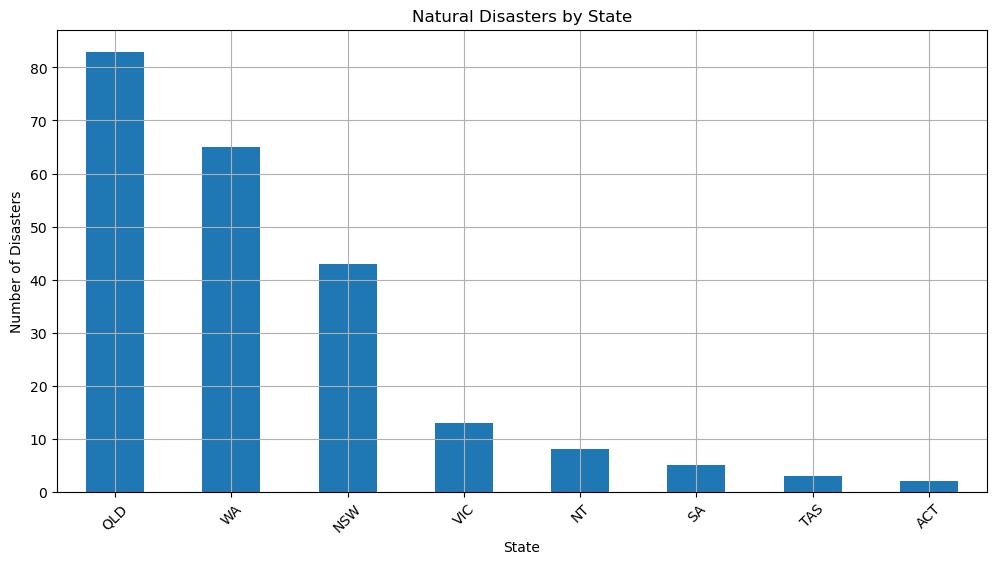

In [760]:
# visual for states with most disasters
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
state_counts.plot(kind='bar')
plt.title("Natural Disasters by State")
plt.xlabel("State")
plt.ylabel("Number of Disasters")
plt.xticks(rotation=45)
plt.grid()
plt.show()


/var/folders/jm/36rrr53s1w388ms7208drrcm0000gn/T/ipykernel_31808/1266782041.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


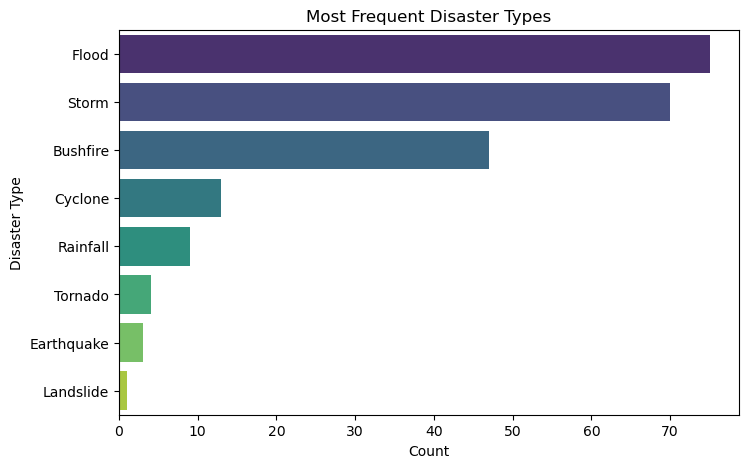

In [761]:
# Visualization: Top disaster types
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(
    y=disaster_counts.index,
    x=disaster_counts.values,
    palette="viridis"
)
plt.title("Most Frequent Disaster Types")
plt.xlabel("Count")
plt.ylabel("Disaster Type")
plt.show()

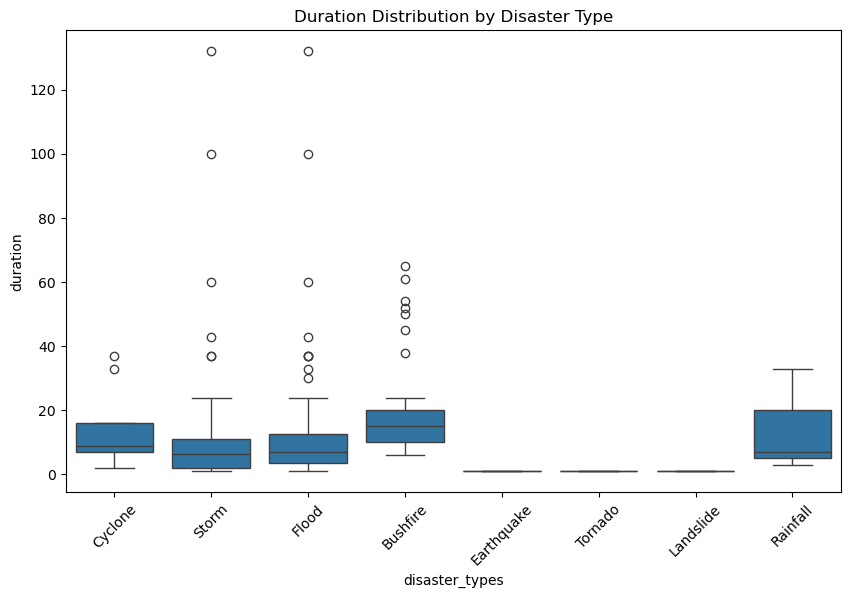

In [762]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(x="disaster_types", y="duration", data=df_disaster_clean_exploded)
plt.title("Duration Distribution by Disaster Type")
plt.xticks(rotation=45)
plt.show()

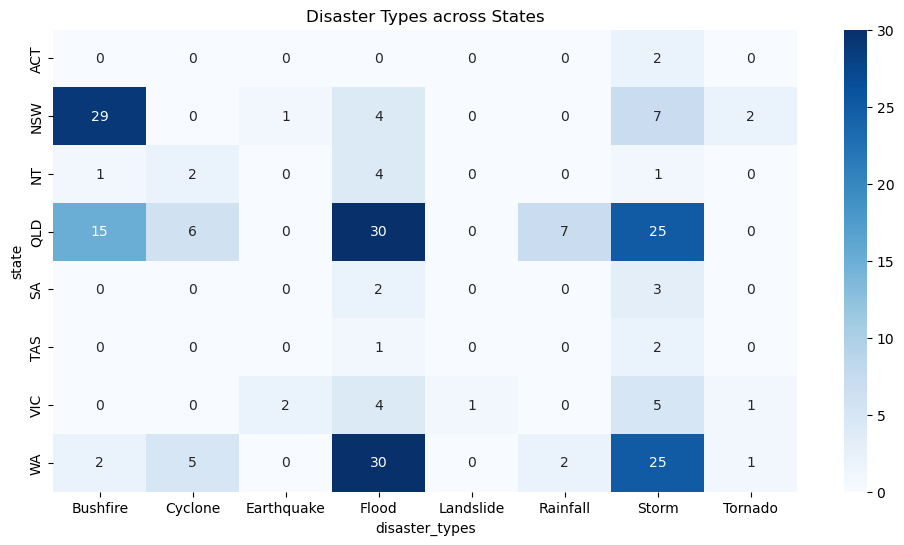

In [763]:
state_type = pd.crosstab(df_disaster_clean_exploded["state"], df_disaster_clean_exploded["disaster_types"])

plt.figure(figsize=(12,6))
sns.heatmap(state_type, cmap="Blues", annot=True, fmt="d")
plt.title("Disaster Types across States")
plt.show()

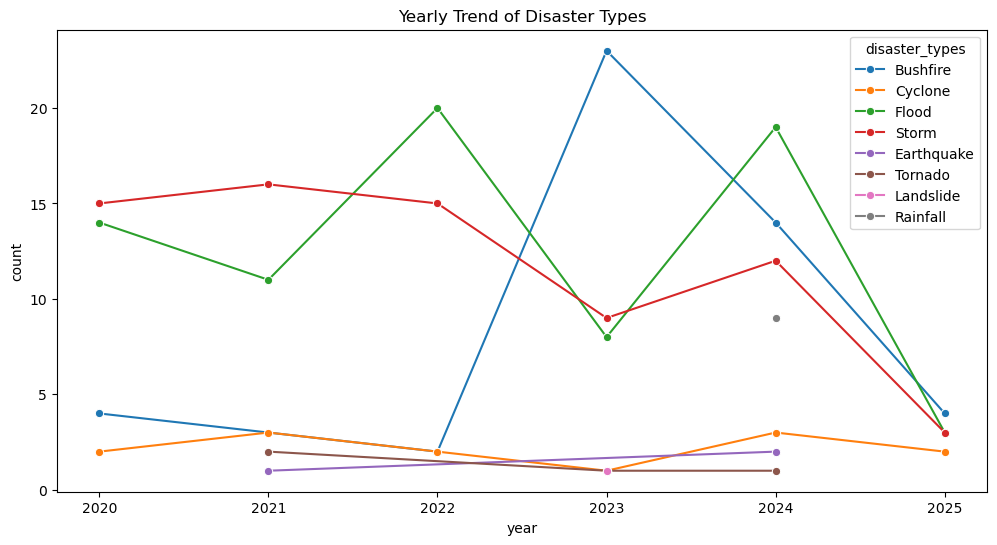

In [764]:
df_disaster_clean_exploded["year"] = df_disaster_clean_exploded["start_date"].dt.year

trend = df_disaster_clean_exploded.groupby(["year","disaster_types"]).size().reset_index(name="count")

plt.figure(figsize=(12,6))
sns.lineplot(x="year", y="count", hue="disaster_types", data=trend, marker="o")
plt.title("Yearly Trend of Disaster Types")
plt.show()

/var/folders/jm/36rrr53s1w388ms7208drrcm0000gn/T/ipykernel_31808/1049439679.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_counts.index, y=month_counts.values, palette="viridis", legend=False)


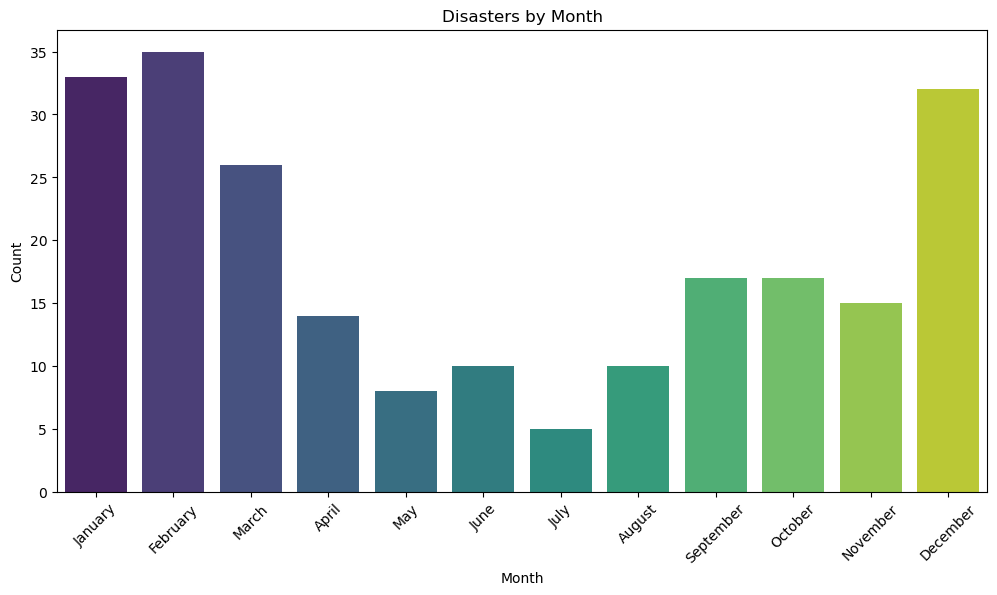

In [767]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add month name column
df_disaster_clean_exploded["month"] = df_disaster_clean_exploded["start_date"].dt.month
df_disaster_clean_exploded["month_name"] = df_disaster_clean_exploded["start_date"].dt.month_name()

# count disasters per month
month_counts = df_disaster_clean_exploded["month_name"].value_counts().reindex(
    ["January","February","March","April","May","June",
     "July","August","September","October","November","December"]
).fillna(0)

# plot
plt.figure(figsize=(12,6))
sns.barplot(x=month_counts.index, y=month_counts.values, palette="viridis", legend=False)
plt.title("Disasters by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

/var/folders/jm/36rrr53s1w388ms7208drrcm0000gn/T/ipykernel_31808/2284986722.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_counts.index, y=season_counts.values, palette="coolwarm", legend=False)


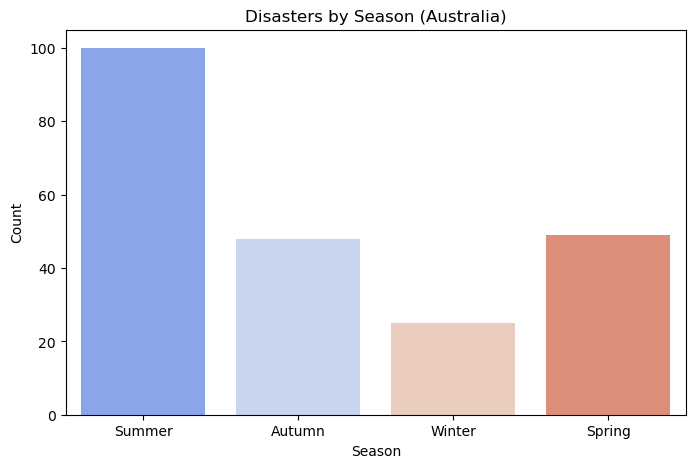

In [768]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map months → seasons (Southern Hemisphere)
season_map = {
    12: "Summer", 1: "Summer", 2: "Summer",
    3: "Autumn", 4: "Autumn", 5: "Autumn",
    6: "Winter", 7: "Winter", 8: "Winter",
    9: "Spring", 10: "Spring", 11: "Spring"
}

df_disaster_clean_exploded["season"] = df_disaster_clean_exploded["month"].map(season_map)

# Count disasters per season
season_counts = df_disaster_clean_exploded["season"].value_counts().reindex(["Summer","Autumn","Winter","Spring"]).fillna(0)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=season_counts.index, y=season_counts.values, palette="coolwarm", legend=False)
plt.title("Disasters by Season (Australia)")
plt.xlabel("Season")
plt.ylabel("Count")
plt.show()